In [16]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import mlflow
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings("ignore")

In [17]:
data = pd.read_csv("../database/cleaned_data.csv", parse_dates=['date'])
data = data.sort_values("date")

### Split the data

In [18]:
train_size = int(len(data) * 0.8)

train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

### Feature Selection with Mutual Info

In [19]:
mi_data = data.drop(columns=['date', 'hospital_id', 'ward_code'])

<Axes: ylabel='Feature'>

<Figure size 1000x800 with 0 Axes>

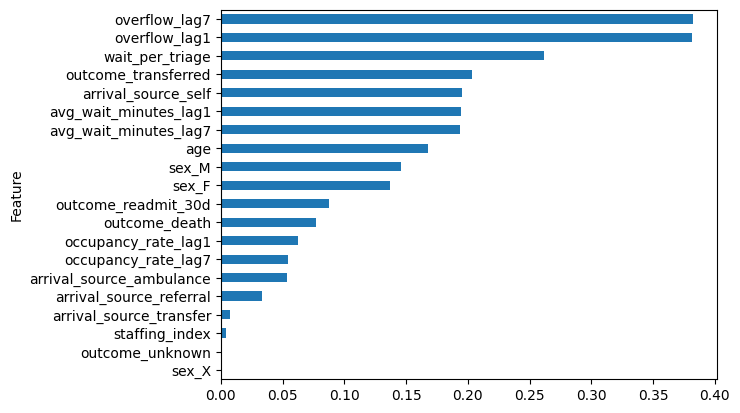

In [20]:
target = mi_data['admissions']
var = mi_data.drop(columns=['admissions'])

from sklearn.feature_selection import mutual_info_regression

mi_scores = mutual_info_regression(var, target, random_state=42)
mi_df = pd.DataFrame(
    {
        'Feature': var.columns,
        'MI_Score': mi_scores
    }
).sort_values('MI_Score', ascending=True)

plt.figure(figsize=(10, 8))
mi_df.head(20).plot(x='Feature', y='MI_Score', kind='barh', legend=False)

### Split data with external features sampled on daily basis

In [21]:
top_features = mi_df['Feature'].head(20).to_list()
exog_features = top_features

X_train = data[exog_features].iloc[:train_size]
y_train = data['admissions'].iloc[:train_size]

X_test = data[exog_features].iloc[train_size:]
y_test = data['admissions'].iloc[train_size:]

In [22]:
top_features = mi_df['Feature'].head(20).to_list()

data = pd.get_dummies(data, columns=['ward_code'], drop_first=False)

bool_cols = data.select_dtypes(include=['bool']).columns
data[bool_cols] = data[bool_cols].astype(int)

ward_cols = [col for col in data.columns if col.startswith('ward_code_')]

exog_features = top_features + ['hospital_id'] + ward_cols

data = data.set_index('date')

weekly_target = data['admissions'].resample('W').mean()
weekly_exog = data[exog_features].resample('W').mean()

weekly_train_size = int(len(weekly_target) * 0.8)
print(weekly_train_size)

X_train = weekly_exog.iloc[:weekly_train_size]
y_train = weekly_target.iloc[:weekly_train_size]

X_test = weekly_exog.iloc[weekly_train_size:]
y_test = weekly_target.iloc[weekly_train_size:]

125


In [23]:
print(len(X_train), len(y_train), len(X_test), len(y_test))

125 125 32 32


### Train SARIMAX using MLFLOW

In [7]:
mlflow.set_experiment("Hospital Admissions Forecasting")

2025/12/04 11:45:05 INFO mlflow.tracking.fluent: Experiment with name 'Hospital Admissions Forecasting' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///c:/Users/hilla.HILLARY/OneDrive/Documents/Desktop/Amdari/Predictive%20Healthcare%20Capacity%20Management/code/model/mlruns/265346645204543020', creation_time=1764848705348, experiment_id='265346645204543020', last_update_time=1764848705348, lifecycle_stage='active', name='Hospital Admissions Forecasting', tags={}>

sarimax_mae: 0.4397667017773468
sarimax_rmse: 0.5207177327323756
sarimax_r2: 0.8971092477122451


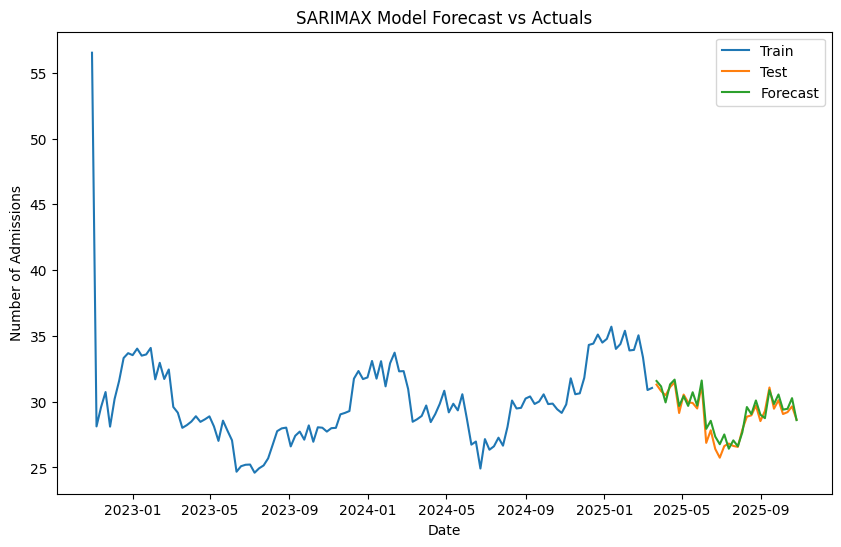

In [24]:
with mlflow.start_run(run_name="SARIMAX model"):
    sarimax_model = SARIMAX(
        endog=y_train,
        exog=X_train,
        order=(2, 1, 3),
        seasonal_order=(0, 0, 0
        , 7),
    ).fit(disp=False)

    sarimax_forecast = sarimax_model.forecast(steps=len(y_test), exog=X_test)
    sarimax_mae = mean_absolute_error(y_test, sarimax_forecast)
    sarimax_rmse = np.sqrt(mean_squared_error(y_test, sarimax_forecast))
    sarimax_r2 = r2_score(y_test, sarimax_forecast)

    print("sarimax_mae:", sarimax_mae)
    print("sarimax_rmse:", sarimax_rmse)
    print("sarimax_r2:", sarimax_r2)


    mlflow.log_param("order", (2, 1, 3))
    mlflow.log_param("seasonal_order", (0, 0, 0, 7))
    mlflow.log_param("exog_features", exog_features)

    mlflow.log_metric("MAE", sarimax_mae)
    mlflow.log_metric("RMSE", sarimax_rmse)
    mlflow.log_metric("R2", sarimax_r2)

    with open("sarimax_model.pkl", 'wb') as f:
        pickle.dump(sarimax_model, f)

    mlflow.log_artifact("sarimax_model.pkl")

    plt.figure(figsize=(10, 6))
    plt.plot(y_train.index, y_train, label="Train") # train
    plt.plot(y_test.index, y_test, label="Test") # test
    plt.plot(y_test.index, sarimax_forecast, label="Forecast") # forecast
    plt.legend()
    plt.title("SARIMAX Model Forecast vs Actuals")
    plt.xlabel("Date")
    plt.ylabel("Number of Admissions")
    plt.savefig("admissions_sarimax_forecast.png")

    mlflow.log_artifact("admissions_sarimax_forecast.png")
    plt.show()




### Hyperparameter Tuning using Auto ARIMA

In [26]:
from pmdarima import auto_arima

model = auto_arima(
    y_train,
    exogenous=X_train,
    seasonal=True,
    m=7,
    start_p=0, max_p=3,
    start_q=0, max_q=3,
    start_P=0, max_P=2,
    start_Q=0, max_Q=2,
    d=None,
    D=None,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    
    stepwise=False, 
    random=True,  
    n_fits=30,   
    random_state=42 
)

print(model.summary())
print(f"Best order: {model.order}")
print(f"Best seasonal_order: {model.seasonal_order}")

 ARIMA(2,1,3)(0,0,0)[7] intercept   : AIC=127255.123, Time=10.91 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=148140.259, Time=0.18 sec
 ARIMA(2,1,1)(1,0,1)[7] intercept   : AIC=128073.250, Time=11.77 sec
 ARIMA(0,1,2)(1,0,1)[7] intercept   : AIC=128782.924, Time=15.65 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=131505.744, Time=6.77 sec
 ARIMA(1,1,3)(0,0,1)[7] intercept   : AIC=127371.487, Time=10.81 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=131512.106, Time=7.86 sec
 ARIMA(0,1,2)(0,0,0)[7] intercept   : AIC=129084.967, Time=10.74 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=147415.713, Time=4.89 sec
 ARIMA(2,1,1)(0,0,1)[7] intercept   : AIC=128072.288, Time=10.28 sec
 ARIMA(2,1,0)(1,0,0)[7] intercept   : AIC=134118.308, Time=3.94 sec
 ARIMA(2,1,0)(2,0,0)[7] intercept   : AIC=134120.106, Time=9.27 sec
 ARIMA(1,1,2)(1,0,1)[7] intercept   : AIC=127506.872, Time=11.98 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=127431.692, Time=12.91 sec
 ARIMA(2,1,0)(1,0,1)[7] intercept   : AI